In [1]:
from scipy import stats
import tensorflow as tf
import math
import itertools
import operator
from tensorflow.python.keras import backend as k
from tqdm import tqdm, tqdm_notebook, notebook
import numpy as np
from tensorflow.keras import layers
import os
from scipy.stats.stats import pearsonr
# from keras.utils.vis_utils import plot_model
# from keras.models import Sequential
# from keras.layers import Activation, LSTM, TimeDistributed, Dense, RepeatVector, CuDNNLSTM, GRU, Bidirectional, Input, CuDNNGRU
# #from keras.utils import np_utils
# from keras.callbacks import TensorBoard
# # import tensorflow as tf

# from keras import backend as K
# from keras.models import Model
# from keras.layers.core import Dense, Reshape
# from keras.layers.wrappers import TimeDistributed
# from keras.layers import concatenate
# import difflib
# from keras.models import load_model
# import keras
# from keras import losses
import matplotlib.pyplot as plt
import random
from random import choice
import re

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle

from sklearn.preprocessing import LabelEncoder
from bio import AlignIO
# from Bio.Align import MultipleSeqAlignment
# from Bio.SeqRecord import SeqRecord
# from Bio import SeqIO
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from keras_preprocessing import sequence
import sklearn
import numpy as np
import re
import pickle
import itertools
import random
import string



/home/mcb/users/dlim63/miniconda3/envs/research/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mcb/users/dlim63/miniconda3/envs/research/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mcb/users/dlim63/miniconda3/envs/research/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", n

In [8]:

# In[3]:


ancName = '_HPGPNRMPC'
desName = 'hg38'
os.environ["CUDA_VISIBLE_DEVICES"]="0"
seq_length = 11
train_size = 0
val_loss_hist = []

#K.clear_session()
#keras.backend.clear_session()

anc = str(np.load('prepData/insert1Anc_{}_{}.npy'.format(ancName, desName)))
des = str(np.load('prepData/insert1Des_{}_{}.npy'.format(ancName, desName)))

In [6]:
anc = np.array(list(anc+'0'))
des = np.array(list(des+'0'))
label_encoder = LabelEncoder()
label_encoder.fit(des)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded_des = label_encoder.transform(des)
integer_encoded_anc = label_encoder.transform(anc)
#one hot the sequence
integer_des = integer_encoded_des.reshape(len(integer_encoded_des), 1)

onehot_encoder.fit(integer_des)
encoded_des =onehot_encoder.transform(integer_des)

integer_anc = integer_encoded_anc.reshape(len(integer_encoded_anc), 1)
encoded_anc = onehot_encoder.transform(integer_anc)

print(encoded_des)
print(encoded_anc)

print(len(encoded_des[0]))
encode_dimension= len(encoded_des[0])

/home/mcb/users/dlim63/miniconda3/envs/research/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
22


In [7]:
print(encoded_des.astype(np.uint8))

[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [22]:
print(label_encoder.inverse_transform(range(encode_dimension)))
print(onehot_encoder.transform(np.ones(1).reshape(-1,1)))
key = list(label_encoder.inverse_transform(range(encode_dimension)))
print(len(key))

['-' '0' 'A' 'C' 'E' 'G' 'O' 'P' 'Q' 'T' 'V' 'W' 'Y' 'c' 'l' 'm' 'p' 'r'
 'u' 'w' 'x' 'y']
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
22


In [9]:
def splice(input, pad):
    result = []
    if pad == False:
        for i in notebook.tqdm(range(int(len(input)/seq_length))):
            result.append(input[i*seq_length:(i+1)*seq_length])
    else :
        for i in notebook.tqdm(range(int(len(input)/seq_length))):
            result.append(np.concatenate((onehot_encoder.transform(np.ones(1).reshape(-1,1)), 
                                         input[i*seq_length:(i+1)*seq_length-1]), 
                                         axis = 0)
                         )
    return np.array(result)

def decoder(input):
    nucleotide = label_encoder.inverse_transform(range(encode_dimension))
    decoded = ''
    for i in tqdm(range(len(input))):
        # decoded= decoded+(nucleotide[np.argmax(onehot_encoder.inverse_transform(input[i].reshape(-1, 1)))])
        #print(np.argmax(input[i]))
        #print(nucleotide)
        decoded= decoded+nucleotide[np.argmax(input[i])]
    return decoded

y = splice(encoded_des, False)
y1 = splice(encoded_des, pad = True)
X = splice(encoded_anc, False)

print(y1.shape)
print(X.shape)
print(X)

onehot_encoder.transform(np.ones(1).reshape(-1,1))
for i in range (100):
    print(decoder(X[i]), decoder(y1[i]), decoder(y[i]))

100%|██████████| 11/11 [00:00<00:00, 45816.63it/s]

(2292728, 11, 22)
(2292728, 11, 22)
[[[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  


100%|██████████| 11/11 [00:00<00:00, 34100.03it/s]


GTGAATCTTGC 0GTGAATCTTG GTGAATCTTGC
ATGCACATTGC 0ATGCACATTG ATGCACATTGC
TAAGTGGAAGA 0TAAGTGGAAG TAAGTGGAAGA
AGACAGTCTGA 0AGACAGTCTG AGACAGTCTGA
GGAGGATACAC 0GGAGGATACA GGAGGATACAC
ACAGTGACTGA 0ACAGTG--TG ACAGTG--TGA
CTTCATTTAAT 0CCTCATTTAA CCTCATTTAAT
GAGATTCTGGA 0GAGACACTGG GAGACACTGGA
GAAGGCAAAAC 0GAAGGC-AAA GAAGGC-AAAC
TACACAGATGG 0TACACAGATG TACACAGATGG
GAAGCCATTGG 0GAAGCCATTG GAAGCCATTGG
CTCCATGGGGT 0CTCCATGGGG CTCCATGGGGT
GGGGGTTTGAA 0GGGGGTTTGA GGGGGTTTGAA
GCATTCCATAT 0GCATTCCATA GCATTCCATAT
GATACTTTAAT 0GATACTTTAA GATACTTTAAT
TGCCACTATGC 0TGCCACAATG TGCCACAATGC
ATTTGTCAAAA 0ATTTGTCAAA ATTTGTCAAAA
CACGCAGAATT 0TATGCAGAAT TATGCAGAATT
TTACAGCCAAA 0TTACAGCCAT TTACAGCCATA
CGGGTAAACCA 0TGGTTAGAGC TGGTTAGAGCA
AATCTATTCAA 0AETCTATTCA AETCTATTCAA
ATTAAATAAAA 0ATTAAATAAA ATTAAATAAAA
TTATTCAGATG 0TTACTCYGAT TTACTCYGATG
TGGAGTACCCA 0TGGAGTuCCC TGGAGTuCCCA
GCACAGAATAC 0GGACAGAATA GGACAGAATAC
ATCATGTGAAA 0ATCATGTGAA ATCATGTGAAA
AAGACATGGGA 0AAGACATGGG AAGACATGGGA
GAGTGAAGGTG 0GAGTGAAGGV GAGT

100%|██████████| 11/11 [00:00<00:00, 43362.17it/s]


CATATTAAAGA 0CATATTAAAG CATATTAAAGA
ACTTCCACCCA 0ACTTCCACTC ACTTCCACTCA
GATTGCAAGAA 0GATTGCAAGA GATTGCAAGAA
AAGAGAGAGGA 0AAGAGAGAGG AAGAGAGAGGA
ATGGAGATGGC 0ATGGAGATGG ATGGAGATGGT
AGCACGAGTCC 0AGCACAAGTC AGCACAAGTCC
CTACAATAAAA 0CTACAATAAA CTACAATAAAA
GCAGATGTTTT 0GTAGATGTTT GTAGATGTTTT
GAGATCAGTTA 0GAGATCAGTT GAGATCAGTTC
TATTTGTTCTG 0TATTTGTTCT TATTTGTTCTG
ACAAAAATTAA 0ACAAAAATTA ACAAAAATTAA
AGACAGAAACC 0AGACAGAAAC AGACAGAAACC
AAAGTTTAGCC 0AAAGTTTAGC AAAGTTTAGCC
TGAGGCTACAA 0TGAGGCAACA TGAGGCAACAA
TTAATTGGGCA 0TTAGTTGGGG TTAGTTGGGGA
ATAAGCCAGAG 0ATAAGCCAGA ATAAGCCAGAG
GCACATATGGC 0GCATATATGG GCATATATGGC
ATAGACAGATT 0ATAGACACAT ATAGACACATT
TAAACATTTCT 0TAAACATTTC TAAACATTTCT
CCCTTATATTA 0CTC--ATATT CTC--ATATTA
ATACAAATACT 0ATACAAATAC ATACAAATACT
AAAATTACAAA 0AAAATGACAT AAAATGACATA
TAAATTGATTC 0TCAATTGATT TCAATTGATTC
CAAATAAAACA 0CAAATAAAAC CAAATAAAACA
AATATTTAAAA 0AATATTTAAA AATATTTAAAA
AATTTAATGAA 0CATTTAATGA CATTTAATGAA


100%|██████████| 11/11 [00:00<00:00, 39773.57it/s]

TAAACACTGGG 0TAAACACTGG TAAACACTGGG
GTCTACAGTAG 0GTCTACAGTA GTCTACAGTAG
TATTTAAAGGA 0TAGTTAAAGG TAGTTAAAGGA
GATCTCACAAA 0GATCTCACAA GATCTCACAAA
CAGGTTTGGTT 0CAGGTTTGGT CAGGTTTGGTT
TTTGAAGGTTA 0TTTGAAGGTT TTTGAAGGTTA
GAACTGATGGT 0GAAATGATGG GAAATGATGGT
CTAGAGAATTC 0CTAGAGAATT CTAGAGAATTC
ATTTCATTCCA 0ATTTCATTCC ATTTCATTCCA
GAGAGAGAAAG 0GAGACAGAAA GAGACAGAAA-
GAGGAATTTCT 0GAGGAATATC GAGGAATATCT
TGGGTTCCTTC 0TGGGTTCCTT TGGGTTCCTTC
AGGAATGCGTC 0AGGAATACAT AGGAATACATC
TGGCTTTGCCT 0TGGCTTTGCC TGGCTTTGCCT
CATCTTTGTGT 0CATCTTTGTG CATCTTTGTGT
GTTTGAACTAT 0GTTTGAACTA GTTTGAACTAT
GCATATGGCAG 0GCATACGGCA GCATACGGCAG


In [10]:
X_train, X_test, y_train1, y_test1, y_train, y_test = train_test_split(
    X, y1, y, test_size=0.2, random_state=42)
# X_train = X[:-300000]
# X_test = X[-300000:]
# y_train1 = y1[:-300000]
# y_test1 = y1[-300000:]
# y_train = y[:-300000]
# y_test = y[-300000:]

def concat(input1, input2):
    result = []
    for x, y in notebook.tqdm(zip(input1, input2)):
        result.append(np.concatenate((x, y), axis=1))
        # print(decoder(x), decoder(y), decoder(np.concatenate((x, y))))
    
    return np.array(result)

y_train1 = concat(X_train, y_train1)
#y_val1 = concatenate(X_val, y_val1)
y_test1 = concat(X_test, y_test1)

# for i in range (100):
#     print(decoder(y_train[i]))
    
nucleotide = label_encoder.inverse_transform(range(encode_dimension))

def decoder(input):
    nucleotide = label_encoder.inverse_transform(range(encode_dimension))
    decoded = ''
    for i in range(len(input)):
        # decoded= decoded+(nucleotide[np.argmax(onehot_encoder.inverse_transform(input[i].reshape(-1, 1)))])
        #print(np.argmax(input[i]))
        #print(nucleotide)
        decoded= decoded+nucleotide[np.argmax(input[i])]
    return decoded

In [11]:
# onehot_encoder.transform(np.ones(1).reshape(-1,1))
# for i in range (100):
#     print(decoder(X_train[i]), decoder(y_train1[i]), decoder(y_train[i]))
# print(y_train1[1])

In [12]:
def printHitMiss(a,b):
    if a==b:
        return 'Hit'
    else:
        return 'Miss'
def accuracy(a, b):
    count = 0
    for i in range(len(a)):
        if a[i] == b[i]:
            count = count+1
    return count/len(a)

def accuracy2(a, b, c):
    count = 0
    count2 =0
    for i in range(len(a)):
        if a[i] != c[i]:
            count2 = count2 +1
        if a[i] != c[i] and b[i]==c[i]:
            count = count+1
    return count/count2

def isMutation(a, b):
    if a!= b:
        print("mutation")

In [1]:
# In[ ]:

def lstm_model(latent_dim, half):
    batch_size = 1000  # Batch size for training.
    epochs = 45  # Number of epochs to train for.
#     latent_dim = 128  # Latent dimensionality of the encoding space.
#     half = 64
    num_samples = 10000  # Number of samples to train on.
    encoder_inputs = layers.Input(shape=(None, encode_dimension))
    
    encoder = layers.Bidirectional(layers.LSTM(half, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
    state_h = layers.concatenate([forward_h, backward_h])
    state_c = layers.concatenate([forward_c, backward_c])
    
    
    # only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder
    decoder_inputs = layers.Input(shape=(None, 2*encode_dimension))
    decoder_lstm = layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states)
    decoder_dense = layers.Dense(encode_dimension, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    # inference
    encoder_model = tf.keras.Model(encoder_inputs, encoder_states)

    decoder_state_input_h = layers.Input(shape=(latent_dim,))
    decoder_state_input_c = layers.Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

    # Run training
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']
                  )
    return model, encoder_model, decoder_model


def modelFit(epoch, batchSize, latent_dim, half, X_train, y_train, y_train1):
    model1, encoder_model1, decoder_model1 = lstm_model(latent_dim, half)
    hist1 = model1.fit([X_train, y_train1], y_train,
          batch_size=batchSize,
          epochs=epoch,
          #validation_data=([X_test,y_test1], y_test),
          validation_split=0.2,
          verbose = 1
         )
    return hist1, model1, encoder_model1, decoder_model1

def grid_search(latent, half,train_size, X_train, y_train, y_train1):
    hist1, model1, encoder_model1, decoder_model1 = modelFit(1, 1000, latent, half, X_train, y_train, y_train1)
    hist2 ,model2, encoder_model2, decoder_model2 = modelFit(2, 1000, latent, half, X_train, y_train, y_train1)
    hist3 ,model3, encoder_model3, decoder_model3 = modelFit(10, 1000, latent, half, X_train, y_train, y_train1)
    #hist4 ,model4, encoder_model4, decoder_model4 = modelFit(30, 1000, latent, half, X_train, y_train, y_train1)
    #hist5 ,model5, encoder_model5, decoder_model5 = modelFit(50, 100, latent, half, X_train, y_train, y_train1)
    #hist6 ,model6, encoder_model6, decoder_model6 = modelFit(80, 100, latent, half, X_train, y_train, y_train1)
    #hist7 ,model7, encoder_model7, decoder_model7 = modelFit(100, 100, latent, half, X_train, y_train, y_train1)
    #hist8 ,model8, encoder_model8, decoder_model8 = modelFit(500, 100, latent, half)

    model1.save("models/insert1_{}_{}_{}_{}_1.h5".format(ancName, desName,train_size,half))
    model2.save("models/insert1_{}_{}_{}_{}_2.h5".format(ancName, desName,train_size,half))
    model3.save("models/insert1_{}_{}_{}_{}_10.h5".format(ancName, desName,train_size,half))
    #model4.save("models/insert1_{}_{}_30_double.h5".format(train_size,half))
    #model5.save("models/_gap_hg38_{}_{}_50_double.h5".format(train_size,half))
    #model6.save("models/_gap_hg38_{}_{}_80_double.h5".format(train_size,half))
    #model7.save("models/_gap_hg38_{}_{}_100_double.h5".format(train_size,half))
    #model8.save("_gap_hg38_{}_{}_500.h5".format(train_size,half))
    
    encoder_model1.save("models/E_insert1_{}_{}_{}_{}_1.h5".format(ancName, desName,train_size,half))
    encoder_model2.save("models/E_insert1_{}_{}_{}_{}_2.h5".format(ancName, desName,train_size,half))
    encoder_model3.save("models/E_insert1_{}_{}_{}_{}_10.h5".format(ancName, desName,train_size,half))
    #encoder_model4.save("models/E_insert1_{}_{}_30_double.h5".format(train_size,half))
    #encoder_model5.save("models/E_gap_hg38_{}_{}_50_double.h5".format(train_size,half))
    #encoder_model6.save("models/E_gap_hg38_{}_{}_80_double.h5".format(train_size,half))
    #encoder_model7.save("models/E_gap_hg38_{}_{}_100_double.h5".format(train_size,half))
    #encoder_model8.save("E_gap_hg38_{}_{}_500.h5".format(train_size,half))
    
    decoder_model1.save("models/D_insert1_{}_{}_{}_{}_1.h5".format(ancName, desName,train_size,half))
    decoder_model2.save("models/D_insert1_{}_{}_{}_{}_2.h5".format(ancName, desName,train_size,half))
    decoder_model3.save("models/D_insert1_{}_{}_{}_{}_10.h5".format(ancName, desName,train_size,half))
    #decoder_model4.save("models/D_insert1_{}_{}_30_double.h5".format(train_size,half))
    #decoder_model5.save("models/D_gap_hg38_{}_{}_50_double.h5".format(train_size,half))
    #decoder_model6.save("models/D_gap_hg38_{}_{}_80_double.h5".format(train_size,half))
    #decoder_model7.save("models/D_gap_hg38_{}_{}_100_double.h5".format(train_size,half))
    #decoder_model8.save("D_gap_hg38_{}_{}_500.h5".format(train_size,half))
    
#     count = [i for i in range(len(hist3.history['val_loss']))]
#     val_loss_hist.append([hist3.history['val_loss'].index(min(hist3.history['val_loss'])),min(hist3.history['val_loss'])])
#     print(val_loss_hist)
#     for i, value in zip(count, hist3.history['val_loss']):
#         print(i, value)

# grid_search(2, 1, 000, X_train, y_train, y_train1)
# grid_search(16, 8, 000, X_train, y_train, y_train1)        
# grid_search(32, 16, 000, X_train, y_train, y_train1)
# grid_search(64, 32, 000, X_train, y_train, y_train1)
# grid_search(128, 64, 000, X_train, y_train, y_train1)
# grid_search(256, 128, 000, X_train, y_train, y_train1)
# grid_search(512, 256, 000, X_train, y_train, y_train1)
grid_search(1024, 512, 000, X_train, y_train, y_train1)
#grid_search(8192, 4096, 000, X_train, y_train, y_train1)

with open('loss_hist.txt', 'wb') as fp:
    pickle.dump(val_loss_hist, fp)

NameError: name 'X_train' is not defined

In [3]:
%precision 2
seq_length = 11
test_size = len(y_test)
val_size = 30000

key = ['-',
 '0',
 'A',
 'C',
 'E',
 'G',
 'O',
 'P',
 'Q',
 'T',
 'V',
 'W',
 'Y',
 'c',
 'l',
 'm',
 'p',
 'r',
 'u',
 'w',
 'x',
 'y']
key = list(label_encoder.inverse_transform(range(encode_dimension)))

mapDict = np.load('mut_dict.npy', allow_pickle = True).item()

rev_dict = {v: k for k, v in mapDict.items()}
#print(rev_dict.keys())
rev_key = []
for item in key:
    #print(item)
    if item in list(rev_dict.keys()):
        rev_key.append(rev_dict[item])
        #print('hi')
    else :
        rev_key.append(item)
print(rev_key)

nucleotide = label_encoder.inverse_transform(range(encode_dimension))

def printHitMiss(a,b):
    if a==b:
        return 'Hit'
    else:
        return 'Miss'
    
def accuracy(a, b):
    count = 0
    for i in range(len(a)):
        if a[i] == b[i]:
            count = count+1
    return count/len(a)

def accuracy2(a, b, c):
    count = 0
    count2 =0
    for i in range(len(a)):
        if a[i] != c[i]:
            count2 = count2 +1
        if a[i] != c[i] and b[i]==c[i]:
            count = count+1
    return count/count2

def isMutation(a, b):
    if a!= b:
        print("mutation")


def decode_sequence(input_seq, model, encoder_model, decoder_model):
    nucleotide = label_encoder.inverse_transform(range(encode_dimension))
    # Encode the input as state vectors.
    #print(input_seq[0,0])
    index = 0
    states_value = encoder_model.predict(input_seq)
    #print(len(states_value))
    #print(states_value)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, encode_dimension*2))
    target_seq[0][0]= np.hstack((input_seq[0,index], onehot_encoder.transform(np.ones(1).reshape(-1,1))[0]))
    #print(target_seq)
    # Populate the first character of target sequence with the start character.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_seq = ''
    probability = 1
    
    while not stop_condition:
        index = index +1
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.random.choice(encode_dimension, 1, p=output_tokens[0, -1, :])[0]
        #list(mapDict.keys())
#         for i in range(len(output_tokens[0])):
#             print(i, dict(zip(rev_key, output_tokens[0][i])))
        sampled_nucleotide = nucleotide[sampled_token_index]
        
        decoded_seq += sampled_nucleotide
        #print(sampled_nucleotide, decoded_seq)
        #print(decoded_sentence)
        # Exit condition: either hit max length
        # or find stop character.
        if (len(decoded_seq) == seq_length):
            break

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, encode_dimension*2))
        temp = np.zeros((encode_dimension))
        temp[sampled_token_index] = 1
        target_seq[0][0]= np.hstack((input_seq[0, index], temp))
        # target_seq[0, 0, sampled_token_index] = 1
        
        
        # Update states
        states_value = [h, c]

    return decoded_seq

def get_prob(input_seq, target, model, encoder_model, decoder_model):
    # Encode the input as state vectors.
    nucleotide = label_encoder.inverse_transform(range(encode_dimension))
    index = 0
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, encode_dimension*2))
    target_seq[0][0]= np.hstack((input_seq[0,index], onehot_encoder.transform(np.ones(1).reshape(-1,1))[0]))

    stop_condition = False
    decoded_seq = ''
    probability = []
    
    while not stop_condition:
        index = index +1
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        sampled_token_index = np.argmax(target[index-1])
        
        probability.append(output_tokens[0, -1, :][sampled_token_index])
        sampled_nucleotide = nucleotide[sampled_token_index]
#         sampled_nucleotide = nucleotide[np.random.choice(encode_dimension, 1, p=output_tokens[0, -1, :])[0]]
        
        decoded_seq += sampled_nucleotide
        if (len(decoded_seq) == seq_length):
            break

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, encode_dimension*2))
        temp = np.zeros((encode_dimension))
        temp[sampled_token_index] = 1
        target_seq[0][0]= np.hstack((input_seq[0, index], temp))
        # target_seq[0, 0, sampled_token_index] = 1
        
        
        # Update states
        states_value = [h, c]

    return decoded_seq, probability

def diffList(a, b):
    count = 0
    length = len(a)
    for i in range(length):
        if a[i] != b[i]:
            count = count+1
    return count

def decoder(input):
    nucleotide = label_encoder.inverse_transform(range(encode_dimension))
    decoded = ''
    for i in range(len(input)):
        # decoded= decoded+(nucleotide[np.argmax(onehot_encoder.inverse_transform(input[i].reshape(-1, 1)))])
        #print(np.argmax(input[i]))
        #print(nucleotide)
        decoded= decoded+nucleotide[np.argmax(input[i])]
    return decoded

#for seq_index in range(1):
def predict2(X_test, y_test, model, encoder_model, decoder_model, gru=False):
    x_true =[]
    y_hat =[]
    y_true =[]
    probList=[]
    generator_output = []
    productProb = [0]*seq_length

    for seq_index in notebook.tqdm(range(len(X_test))):
        input_seq = X_test[seq_index: seq_index + 1]
        if gru:
            decoded_sentence = decode_gru(input_seq, model, encoder_model, decoder_model)
        else :
            decoded_sentence = decode_sequence(input_seq, model, encoder_model, decoder_model)
        _, prob = get_prob(input_seq, y_test[seq_index], model, encoder_model, decoder_model)
        prob = [math.log(x) for x in prob]
        productProb = [sum(x) for x in zip(productProb, prob)]
        input_sen = decoder(input_seq[0])
#         inputAll = inputAll + input_sen
#         predAll = predAll + decoded_sentence
#         outputAll = outputAll + decoder(y_test[seq_index])
#         print(input_sen, ' -> ',
#               decoded_sentence, 'True:', decoder(y_test[seq_index]), 
#               printHitMiss(decoded_sentence, decoder(y_test[seq_index]))
#               #diffList(input_sen, decoded_sentence)
#              )
#         print(input_sen, ' -> ',
#               decoder(y_test[seq_index]), 'True:', decoder(y_test[seq_index]), 
#               prob,
#               printHitMiss(decoded_sentence, decoder(y_test[seq_index]))
#               #diffList(input_sen, decoded_sentence)
#              )
        x_true.append(input_sen)
        y_hat.append(decoded_sentence)
        y_true.append(decoder(y_test[seq_index]))
    #generator_output.append(input_sen+decoded_seq)
    print(productProb)
    productProb = [x/test_size for x in productProb]
    print("Sum of log probabilities : {}".format(productProb))
    print("Percentage of target and prediction being identical: {}".format(accuracy(y_hat, y_true)))
    print("Percentage of training and prediction being identical: {}".format(accuracy(y_hat, x_true)))
    print("Accuracy given mutation happened : {}".format(accuracy2(x_true, y_hat, y_true)))
    #np.save('data/hg38_output.npy', generator_output)
    
    return x_true, y_hat, y_true

def grid_predict(train_size, half, epoch, X_test, y_test):
    model1 = tf.keras.models.load_model("models/insert1_{}_{}_{}_{}_{}.h5".format(ancName, desName,train_size,half,epoch))

    encoder_model1 = tf.keras.models.load_model("models/E_insert1_{}_{}_{}_{}_{}.h5".format(ancName, desName,train_size,half, epoch))

    decoder_model1 =tf.keras.models.load_model("models/D_insert1_{}_{}_{}_{}_{}.h5".format(ancName, desName,train_size,half, epoch))

    inputAll, predAll, outputAll = predict2(X_test, y_test, model1, encoder_model1, decoder_model1, gru=False)
    
    return inputAll, predAll, outputAll
    

def concat(input1, input2):
    result = []
    for x, y in zip(input1, input2):
        result.append(np.hstack((x, y)))
    
    return np.array(result)

# def get_data(trainInd, valInd, testInd):
#     X_train=np.load('prepData/X_train_gap_hg38_v3_chr2_size10.npy')[:trainInd]
#     X_val=np.load('prepData/X_val_gap_hg38_v3_chr2_size10.npy')[:valInd]
#     X_test=np.load('prepData/X_test_gap_hg38_v3_chr2_size10.npy')[:testInd]
#     y_train=np.load('prepData/y_train_gap_hg38_v3_chr2_size10.npy')[:trainInd]
#     y_val=np.load('prepData/y_val_gap_hg38_v3_chr2_size10.npy')[:valInd]
#     y_test=np.load('prepData/y_test_gap_hg38_v3_chr2_size10.npy')[:testInd]

#     y_train1 = np.load('prepData/y_train1_gap_hg38_v3_chr2_size10.npy')[:trainInd]
#     y_val1 = np.load('prepData/y_val1_gap_hg38_v3_chr2_size10.npy')[:valInd]
#     y_test1 = np.load('prepData/y_test1_gap_hg38_v3_chr2_size10.npy')[:testInd]

#     y_train1 = concat(X_train, y_train1)
#     y_val1 = concat(X_val, y_val1)
#     y_test1 = concat(X_test, y_test1)
#     return X_test, y_test



# hidden = [16, 32, 64,128,256,512]
# epoch = [10, 10, 2, 2, 2, 1]
hidden = [512]
epoch = [10]
#X_test, y_test = get_data(train_size, val_size, test_size)
for h, e in zip(hidden, epoch):
    print("Anc : {}, Des : {}, Train size = {}, hidden_size = {}, epoch = {}".format(ancName, desName, train_size, h, e))
    inputAll, predAll, outputAll = grid_predict(train_size, h, e, X_test, y_test)
    print("The end of Anc : {}, Des : {}, Train size = {}, hidden_size = {}, epoch = {}".format(ancName, desName,train_size, h, e))
    

    

# mapDict = {'A': 'A', 'C': 'C', 'G': 'G', 'T': 'T', '-': '-', 'AA': 'O', 'AC': 'h', '0': '0',
#        'AT': 'b', 'AG': 'V', 'CA': 'r', 'CC': 'p', 'CT': 'o', 'CG': 'i', 'TA': 'g', 
#        'TC': 'I', 'TT': 'f', 'TG': 'L', 'GA': 'B', 'GC': 'c', 'GT': 'X', 'GG': 'P'}

NameError: name 'y_test' is not defined

In [2]:
def string_to_array(my_string):
    my_string = my_string.lower()
    my_string = re.sub('[^acgt0]', 'z', my_string)
    my_array = np.array(list(my_string))
    return my_array

def readmaf(start, end, filename):
    count = 0
    oldlist =[]
    align = AlignIO.parse(filename, "maf")

    for multiple_alignment in tqdm(align):
        count = count+1
        if count >start and count<=end:
            oldlist.append(multiple_alignment)
        elif count>end:
            break
    return oldlist

oldlist = readmaf(0, 23000, "data/HU_RH_MO_RA_EL_SH_PI_CO_MI_CA.anc.maf")

def getAlign(inputList):
    alignList = []
    zeros = ''
    anc = ''
    des = ''
    for i in range(len(inputList)):
        # index for the dog
        indexDes = -1
        indexAnc = -1

        for j in range(len(inputList[i])):
            if len(inputList[i][j])>=10 and 'Human.chr22' in inputList[i][j].id  :
                indexDes = j
            elif len(inputList[i][j])>=10 and inputList[i][j].id == '_HRMR': #'_RMPC' :
                indexAnc = j
        if indexDes!=-1 and indexAnc!=-1:
            des = des+str(inputList[i][indexDes].seq)
            anc = anc+str(inputList[i][indexAnc].seq)

    return anc.upper(), des.upper()

def decodeDictSeq(anc, des, mut_dict):
    newAnc = ''
    newDes = ''
    for i in range(len(anc)):
        if len(mut_dict[des[i]]) == 1:
            newAnc += mut_dict[anc[i]]
            newDes += mut_dict[des[i]]
        elif len(mut_dict[des[i]]) ==2:
            newAnc += mut_dict[anc[i]]
            newAnc += '-'
            newDes += mut_dict[des[i]]
    return newAnc, newDes

mut_dict = np.load('mut_dict.npy',allow_pickle=True).item()
mut_dict = {v: k for k, v in mut_dict.items()}
evol_anc, evol_des = getAlign(oldlist)
evol_anc = [evol_anc[i: i + seq_length] for i in range(0, len(evol_anc), seq_length)][:-1]
evol_des = [evol_des[i: i + seq_length] for i in range(0, len(evol_des), seq_length)][:-1]

22575it [00:03, 7327.61it/s]


NameError: name 'seq_length' is not defined

In [3]:
contextLen = 2
numBin = 10
def contextMut(size, ancNuc, desNuc, anc, des, pred, evol, lstm = False):
    cont = list(itertools.product('ACGT-', repeat=size))
    context_dict = {}
    count_dict = {}
    for i in cont:
        for j in cont:
            #context_dict[(''.join(i)+'A'+''.join(j) , ''.join(i)+'G'+''.join(j))] = 0
            context_dict[(''.join(i)+ancNuc+''.join(j))] = 0
            count_dict[(''.join(i)+ancNuc+''.join(j))] = 0
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2):
            if a[i+size] == ancNuc :
                count_dict[(a[i:i+size*2+1])] += 1
    for a,b in zip(anc, des):
        for i in range(len(a)-size*2):
            if a[i+size] == ancNuc and b[i+size] == desNuc:
                context_dict[(a[i:i+size*2+1])] += 1
    for key in context_dict.keys():
        if count_dict[key] !=0:
            context_dict[key] = context_dict[key]/count_dict[key] 
        else :
            continue
    sorted_context = sorted(context_dict.items(), key=operator.itemgetter(1), reverse = 1)
    sorted_context = dict(sorted_context)
    if lstm ==False:
        if pred == True and evol ==False:
            np.save('data/pred_context{}{}.npy'.format(ancNuc,desNuc), sorted_context)
        elif pred == True and evol == True:
            np.save('data/pred_evol_context{}{}.npy'.format(ancNuc,desNuc), sorted_context)
        elif pred == False and evol ==False:
            np.save('data/true_context{}{}.npy'.format(ancNuc,desNuc), sorted_context)
        elif pred == False and evol ==True:
            np.save('data/true_evol_context{}{}.npy'.format(ancNuc,desNuc), sorted_context)
        return sorted_context
    elif lstm ==True :
        if pred == True:
            np.save('data/pred_lstm_context{}{}.npy'.format(ancNuc,desNuc), sorted_context)
        elif pred ==False:
            np.save('data/true_lstm_context{}{}.npy'.format(ancNuc,desNuc), sorted_context)
            
def decodeList(inputAll, predAll, outputAll):
    inp =[]
    inp2 = []
    pre = []
    out = []
    for i, p, o in tqdm(zip(inputAll, predAll, outputAll)):
        input, pred = decodeDictSeq(i, p, mut_dict)
        input2, output = decodeDictSeq(i,o, mut_dict)
        inp.append(input)
        inp2.append(input2)
        pre.append(pred)
        out.append(output)
    return inp, inp2, pre, out
            

# np.save('inputAll_{}_{}'.format(ancName, desName), inputAll)
# np.save('predAll_{}_{}'.format(ancName, desName), predAll)
# np.save('outputAll_{}_{}'.format(ancName, desName), outputAll)

inputAll = np.load('inputAll__HPGPNRMPC_hg38.npy')
predAll = np.load('predAll__HPGPNRMPC_hg38.npy')
outputAll = np.load('outputAll__HPGPNRMPC_hg38.npy')

lstm_inputAll = np.load('inputAll_lstm__HPGPNRMPC_hg38.npy')
lstm_predAll = np.load('predAll_lstm__HPGPNRMPC_hg38.npy')
lstm_outputAll = np.load('outputAll_lstm__HPGPNRMPC_hg38.npy')

# inputAll, inputAll2, predAll, outputAll= decodeList(inputAll, predAll, outputAll)
# lstm_inputAll, lstm_inputAll2, lstm_predAll, lstm_outputAll = decodeList(lstm_inputAll, lstm_predAll, lstm_outputAll)

ancCase = ['A','C','G','T','-']
desCase = ['A','C','G','T','-']
for i in tqdm_notebook(ancCase):
    for j in desCase:
        contextMut(contextLen, i, j, inputAll, predAll, pred = True, evol = False)
        contextMut(contextLen, i, j, inputAll, outputAll, pred = False, evol = False)
        contextMut(contextLen, i, j, lstm_inputAll, lstm_predAll, pred = True, evol = False, lstm = True)
        contextMut(contextLen, i, j, evol_anc, evol_des, pred = False, evol = True)

/home/mcb/users/dlim63/miniconda3/envs/research/lib/python3.7/site-packages/ipykernel_launcher.py:75: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [4]:
for i in range(1000):
    print(outputAll[i])

TTTTCCTCCTA
GGCAGGCAAGG
AGTTTTGGACT
CCCAAAGAGTG
GTAGAGTTTTA
CAAACCACTTG
ACCTCCAGCAT
CTCTGGGGACC
ATTCACACTCT
AGGTAGCAGAT
CTGGCTTCAGC
TACATTTCCGG
TCAACCTTTCC
CTGCAGCTTTG
AACATTTCCAG
CCCTCTTCTTT
TTTTTACACCT
GACTCATGTTT
GCCAGGGCCAT
AATTGGCTACA
TGGCACAAGTG
CAGGGGTGCTG
AGGGAAGCCGG
AAATTATCAAA
TGGGGGAAGTT
TTTCAATTGTA
GAAGCGAGATT
TTTTCTTCAGT
AGATGGAGCGA
AAAAA-ACAAT
ATAAAAATGAA
AGGACAGATAG
TGTATGTGACT
CCGGGCTCTC-
TTGAGGTTGTC
TTGGCCTTTTG
TACCTCTTCTC
CTCAGCAAAAT
AACATTTCATC
TTTAGAAATCA
ACTTTGCTGGA
ATGCAGCACTT
CACTATTATCA
GATAGAAGCAA
CTACTCATGGT
CCCGGGGCGGG
CCTAGAGCCTG
CCTGTGGACAC
GTACCCGTAT-
AACCAGAACAC
AAAGCCACCTG
CAGAGCGAGAC
GCTCAACAAAA
CTCATACAGTA
CTCAAGCTTTC
TTGAAGAAATG
AGTGACATGTT
ATTATAGTCAA
TACCACAAAGA
CTTTTAGCACA
GCACCCACCAC
TGGTGGGCTGA
TCCTGACCACA
TTCAAGCAATT
AGAGGAAGACG
TTTTTCTCAAA
CCCTAAATAAA
CCAAGACTGGA
TAGTCACATAA
GCAGAAGGGAG
ACGTAATAATT
CTTGGTAAAAT
ATATAACCCAT
CCTTGCATAGG
AATTTTCTTGT
TTTCTCTCTCT
TTTATTATTTT
TTGAATTGATT
CTTCTCCCAAG
GGTCCTTCTTT
ACAGAGAATCT
ACTCCCCAGAG
GACAAAGCATG
GGGG

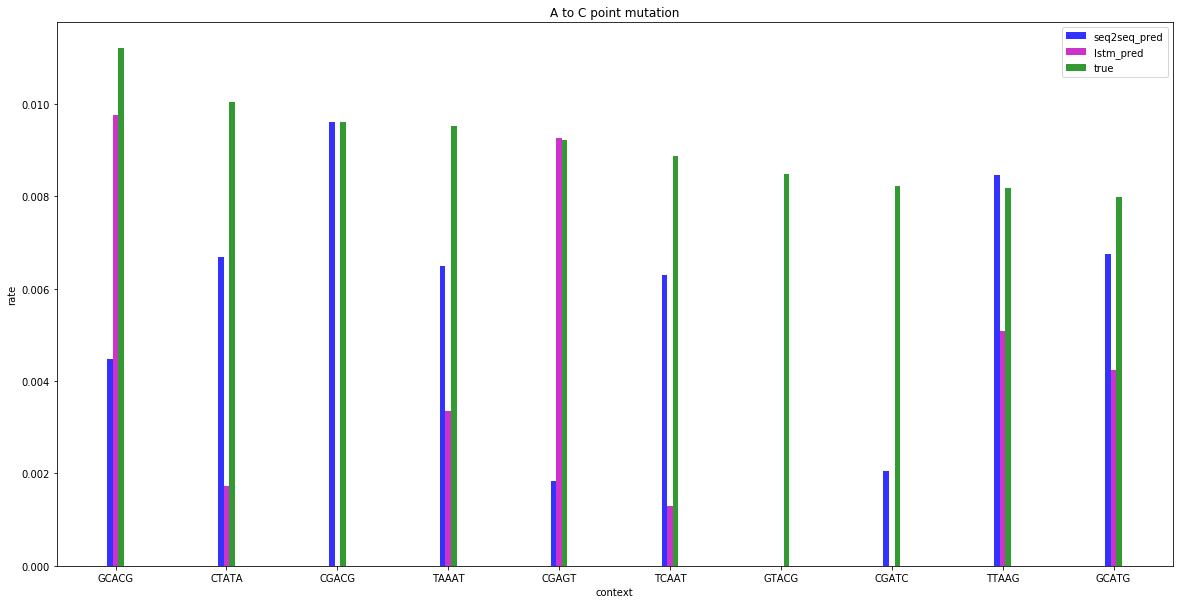

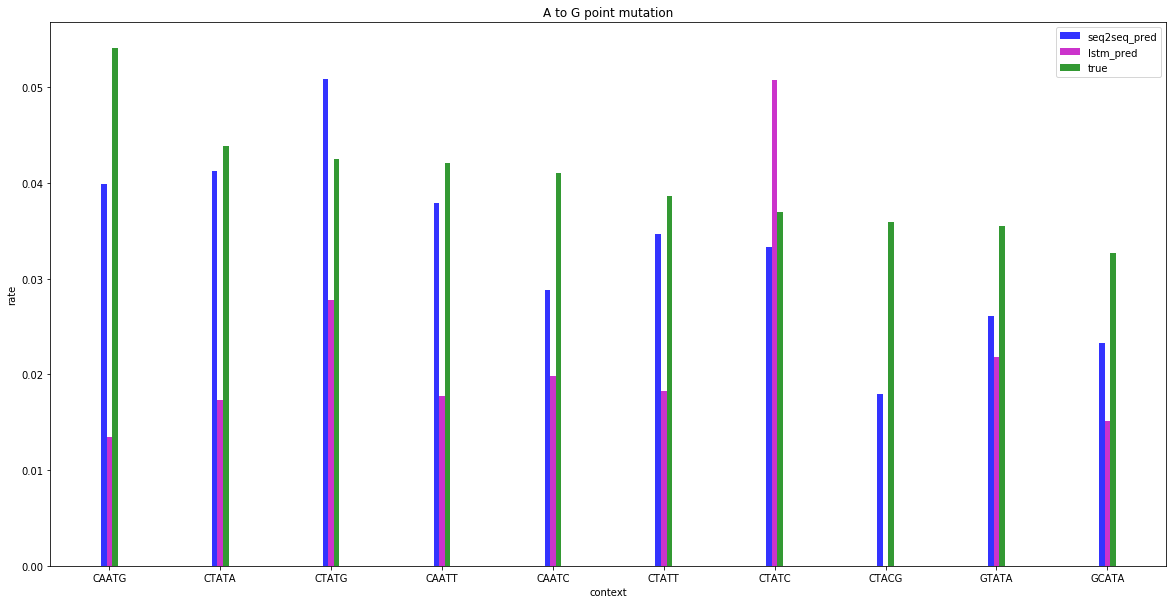

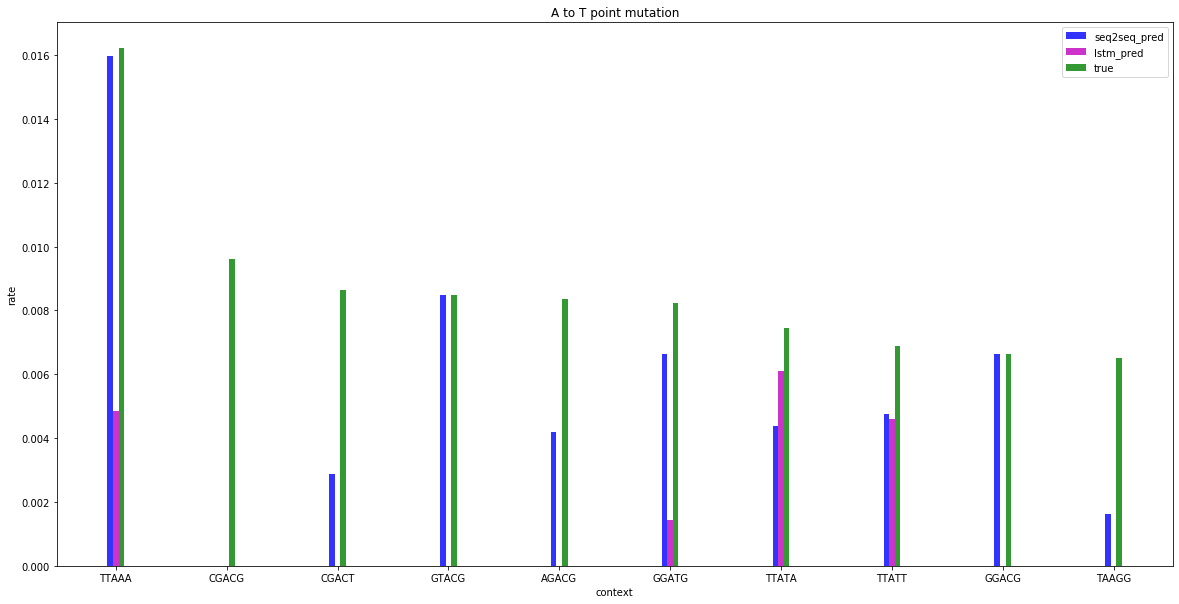

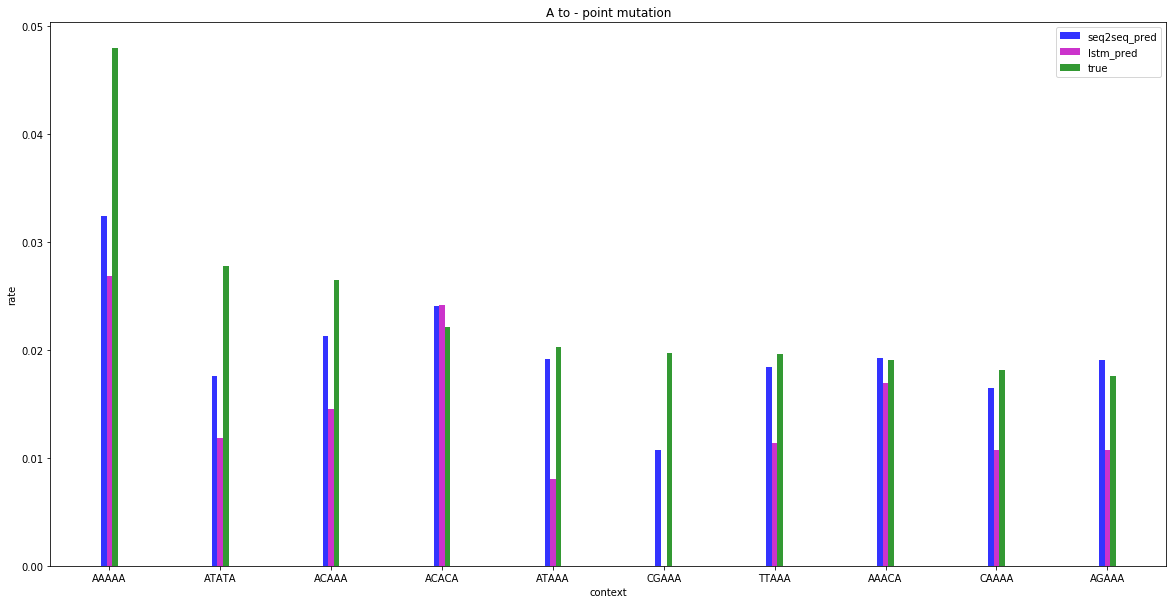

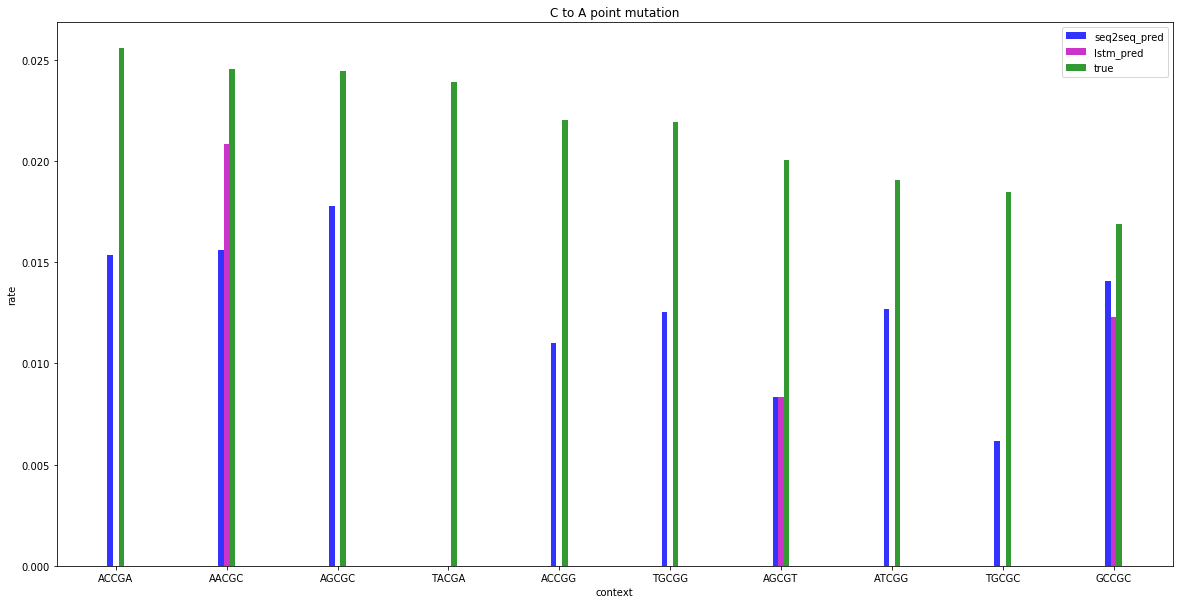

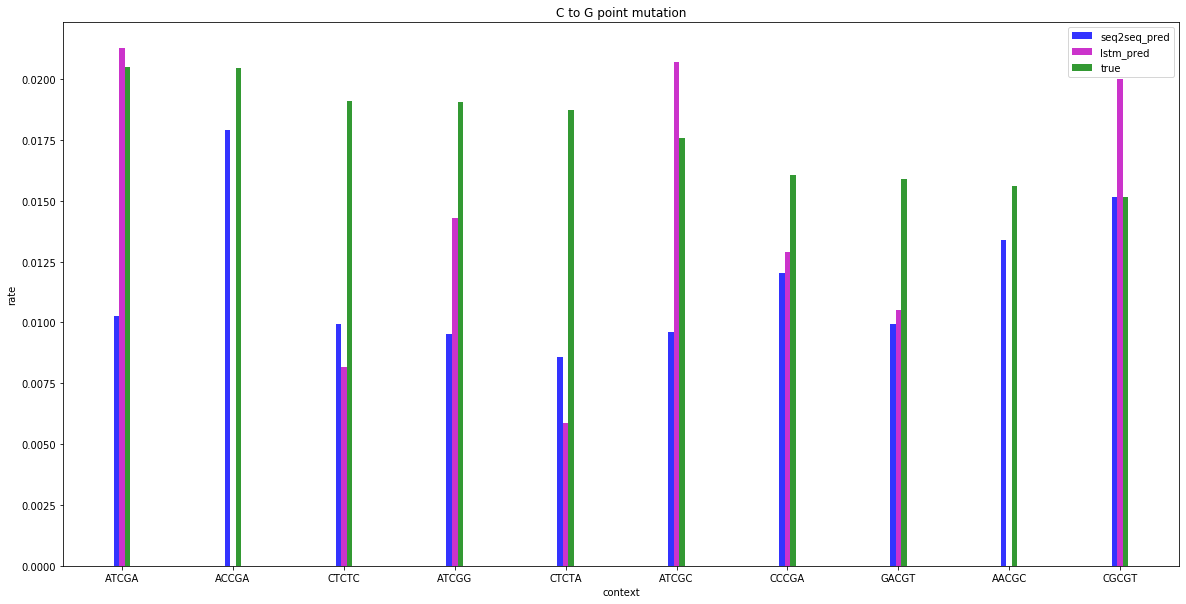

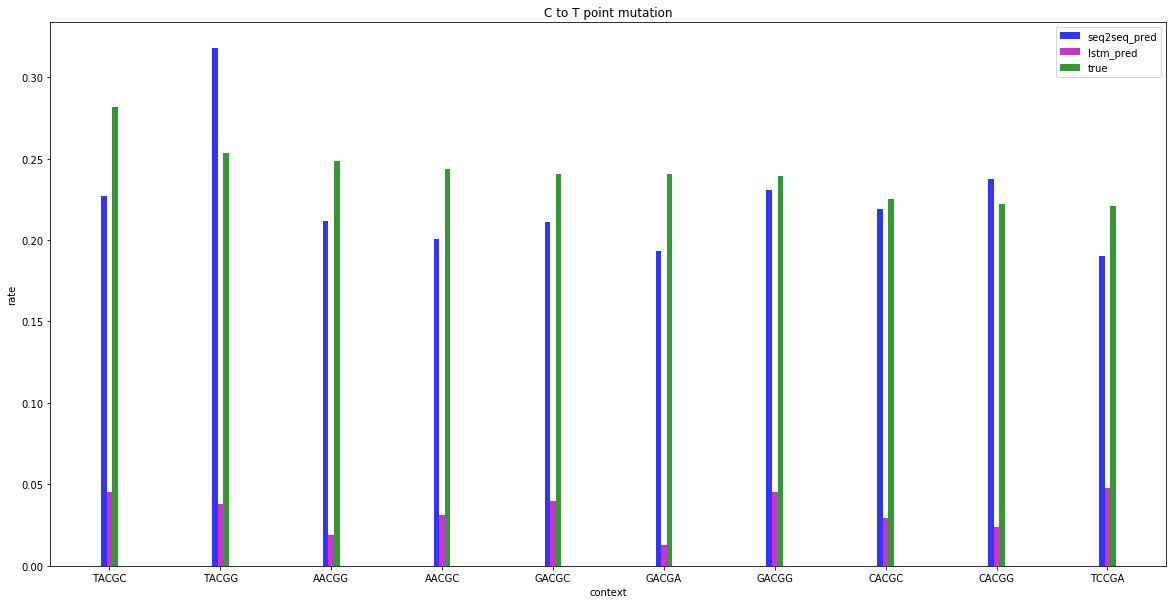

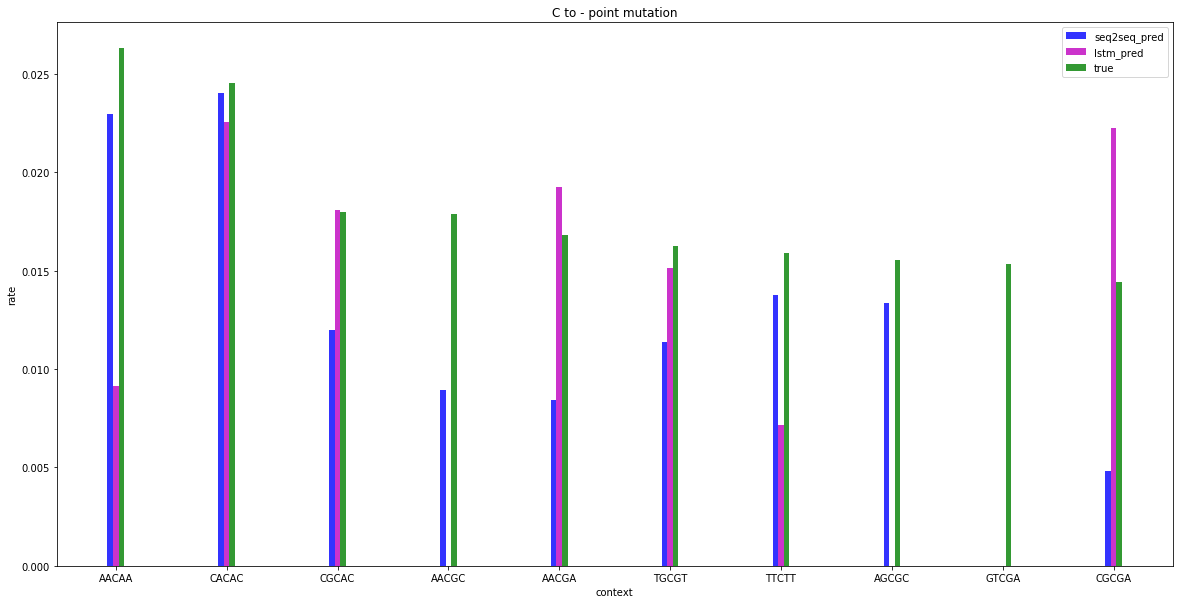

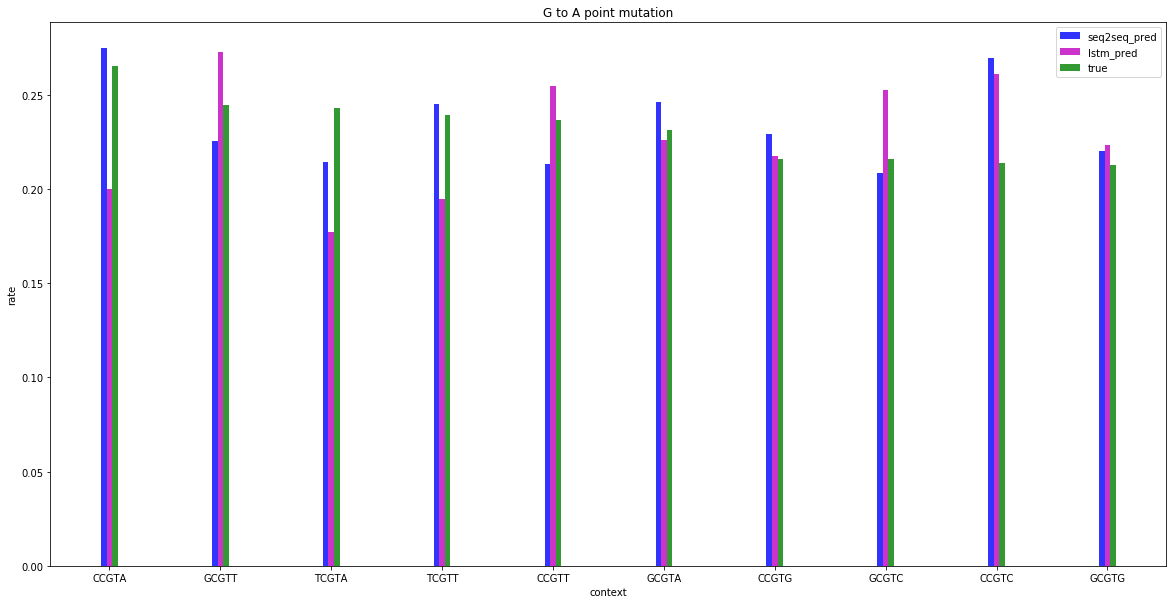

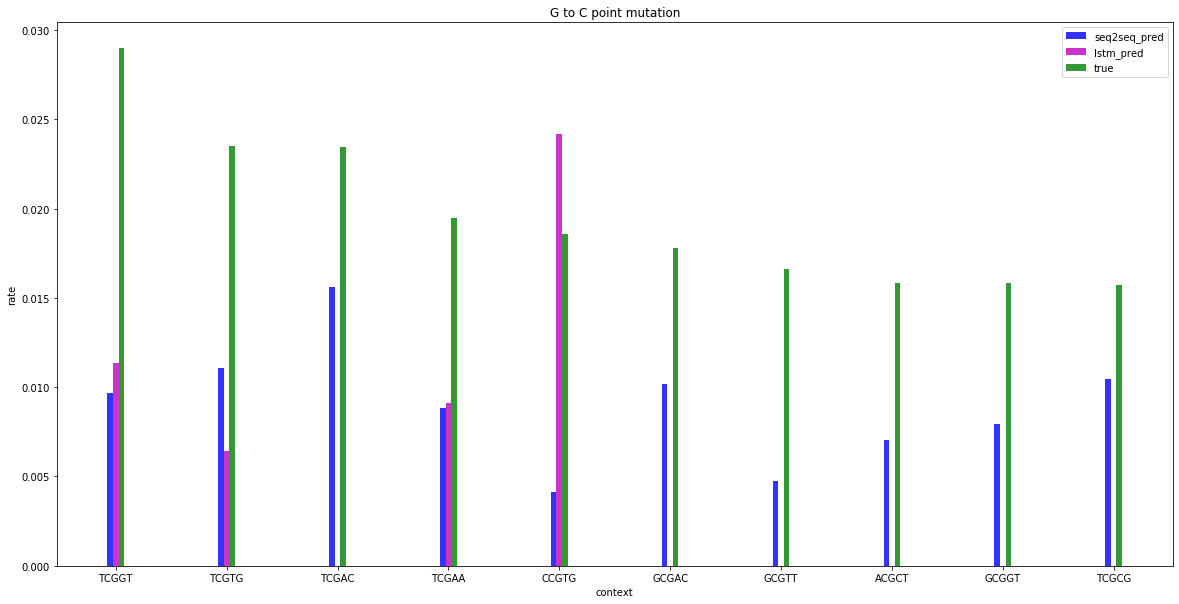

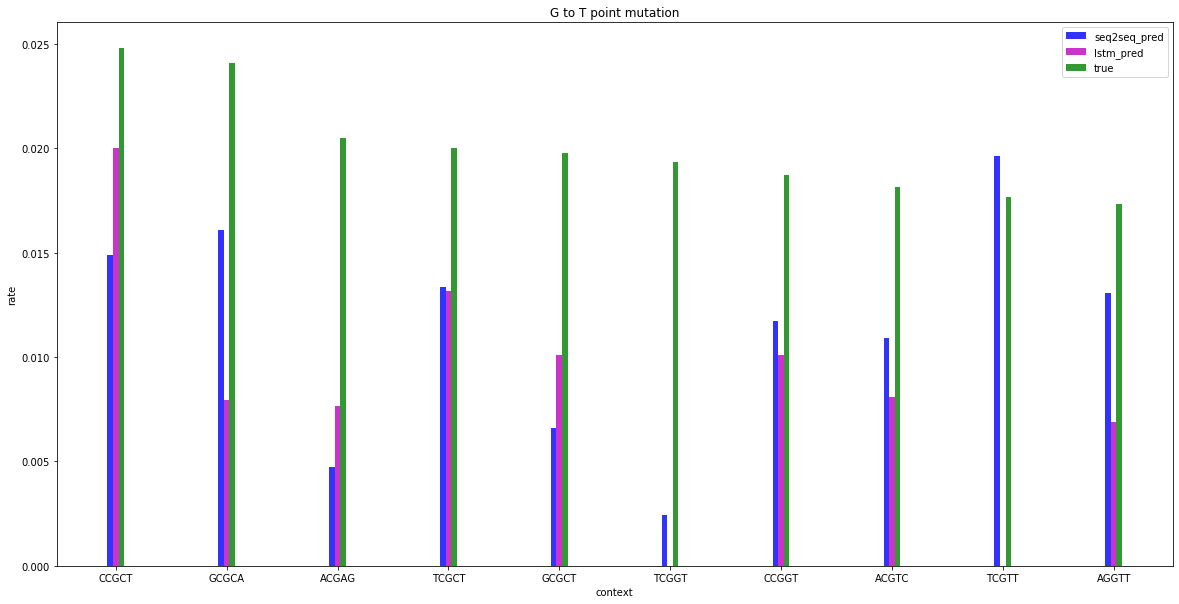

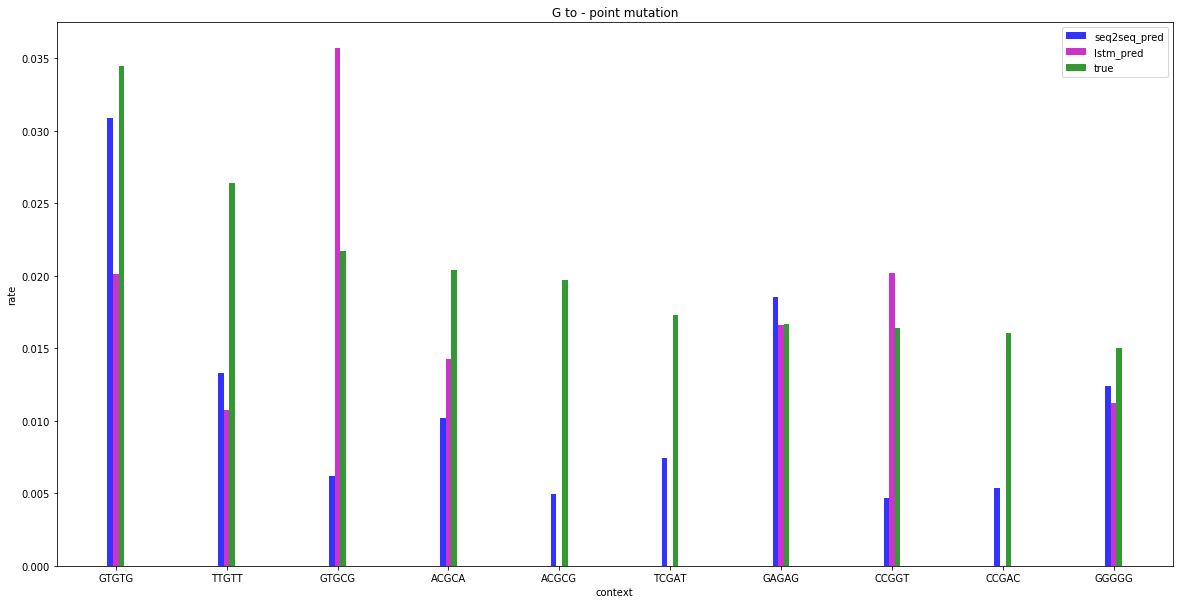

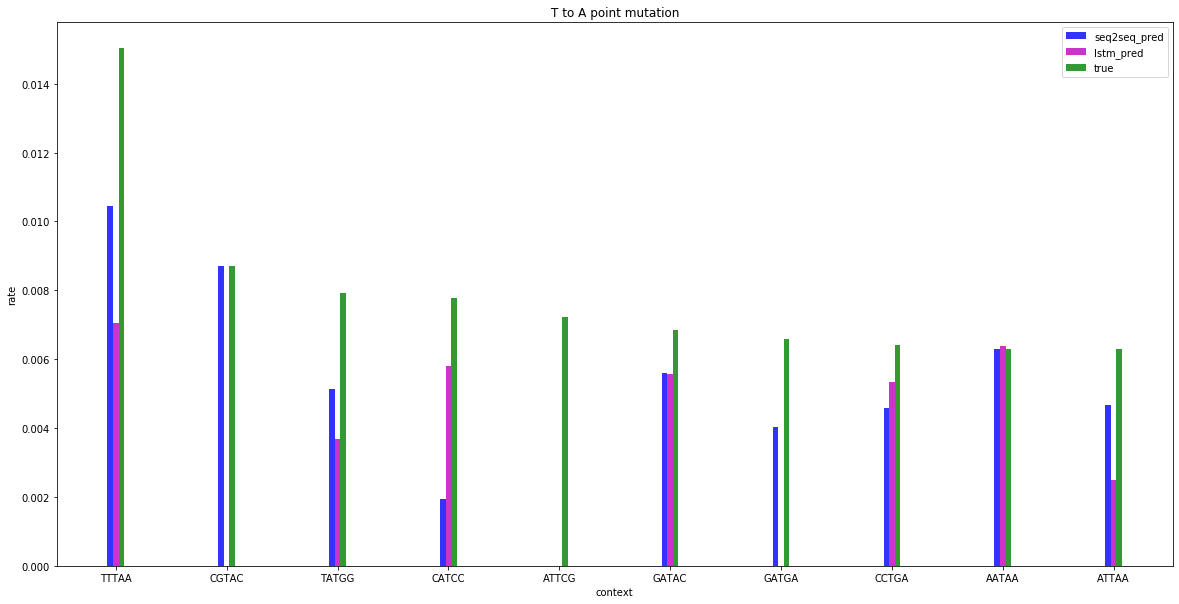

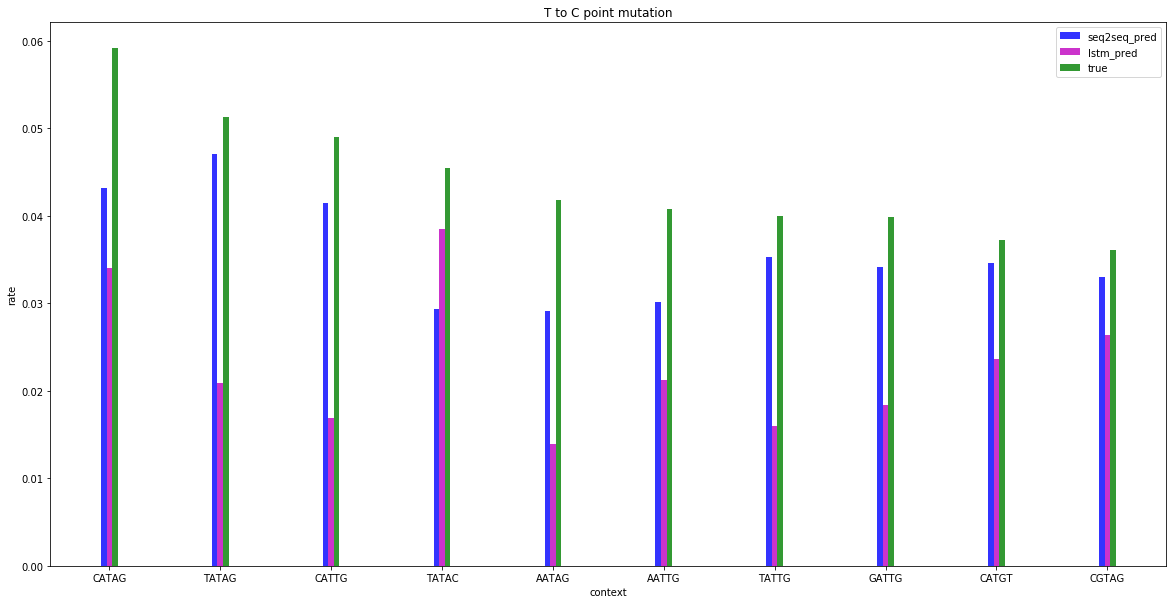

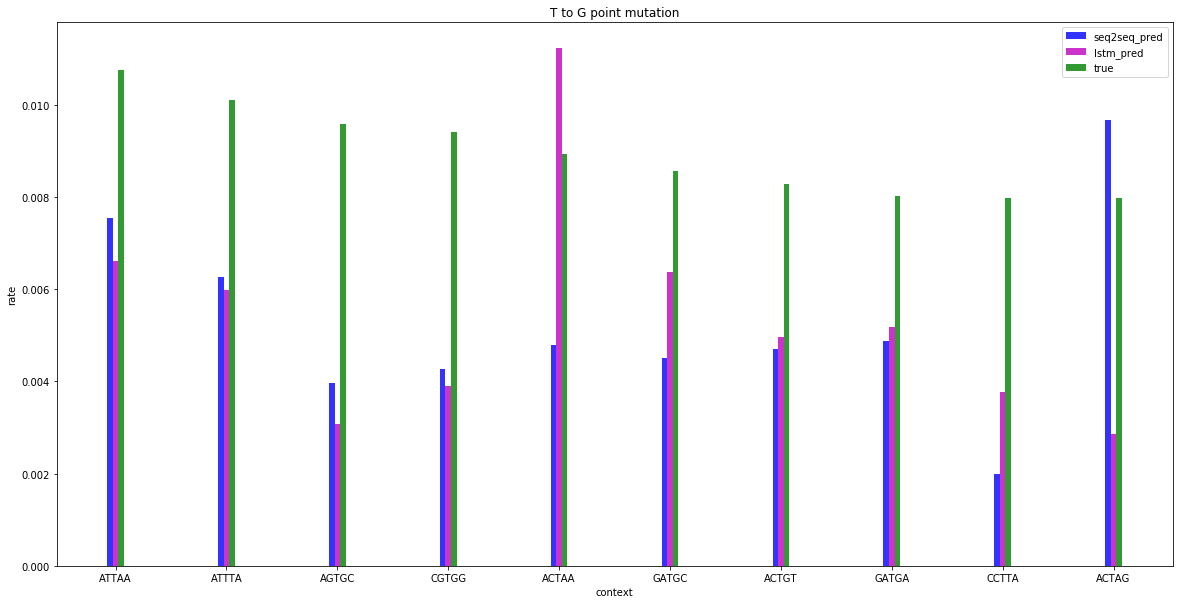

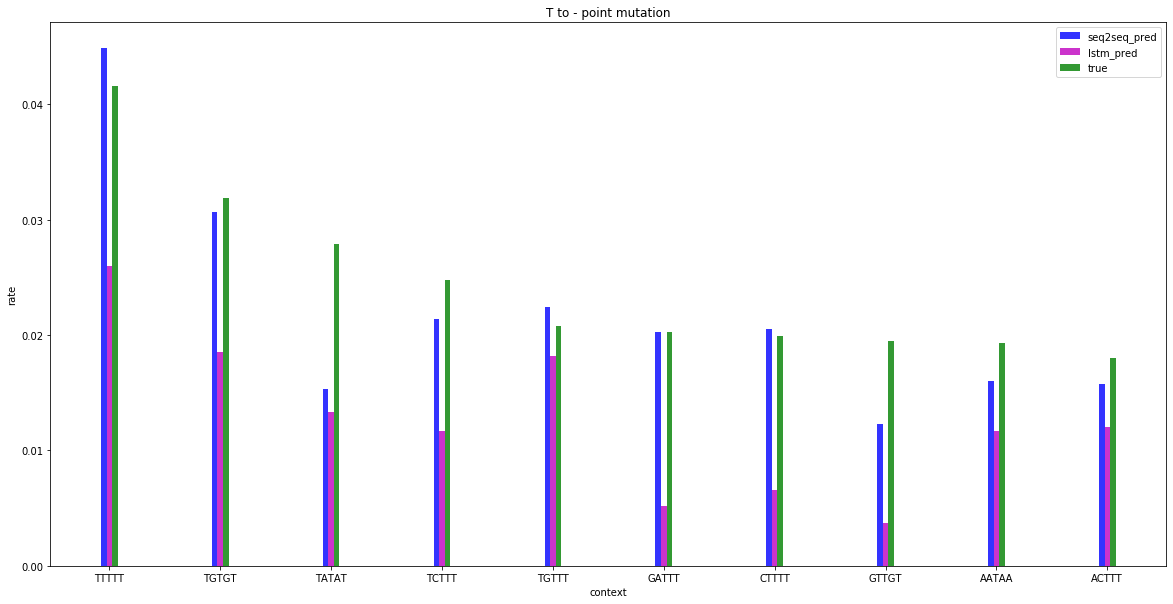

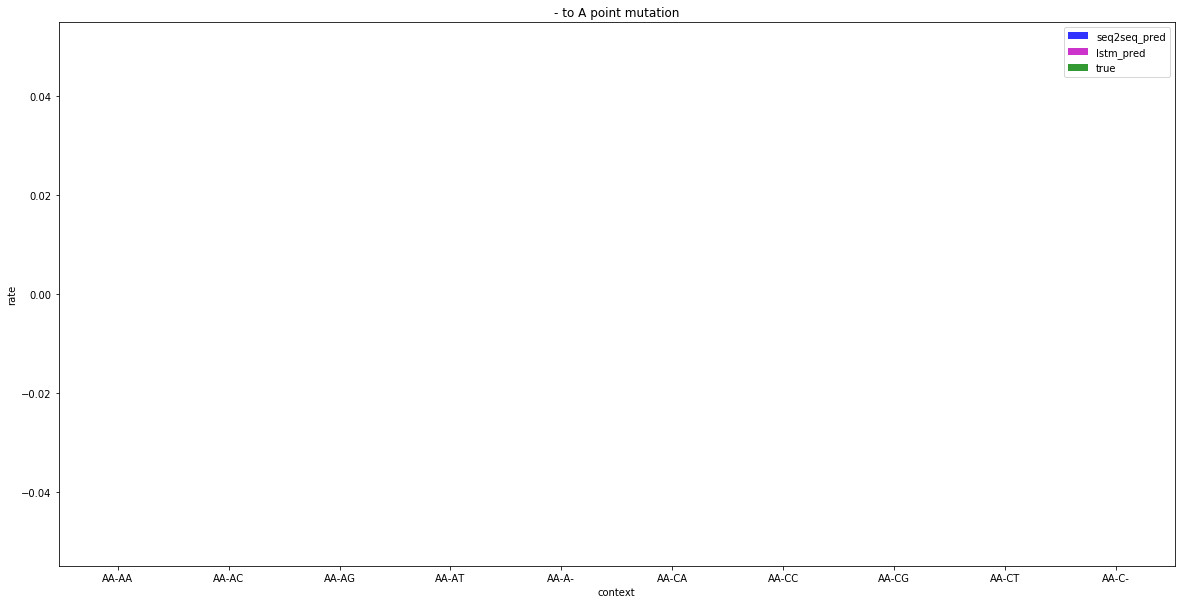

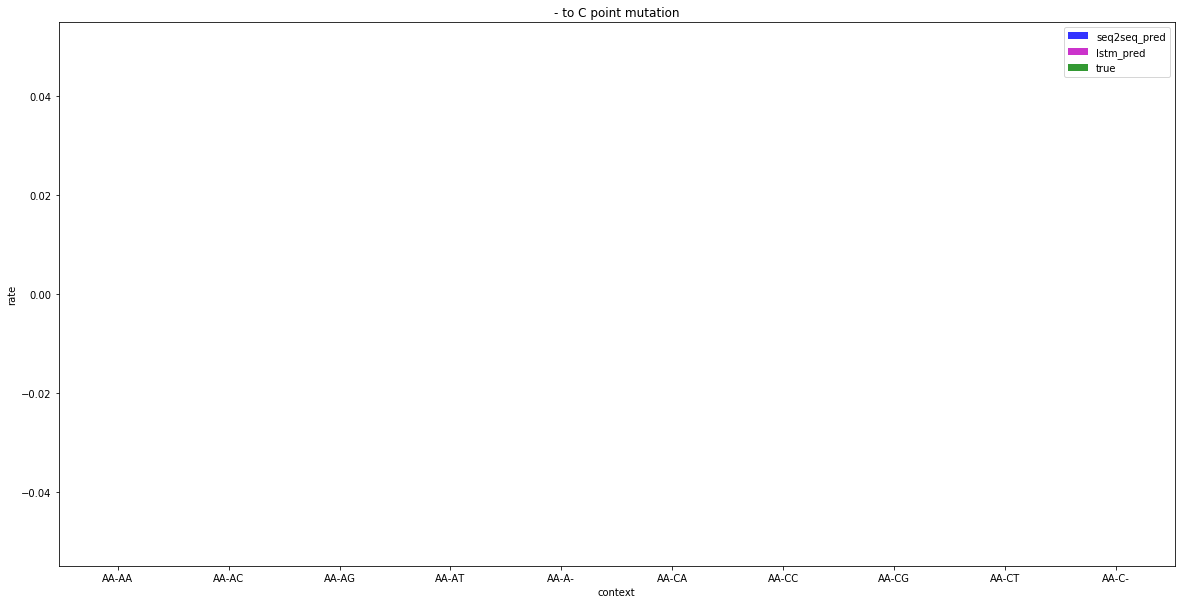

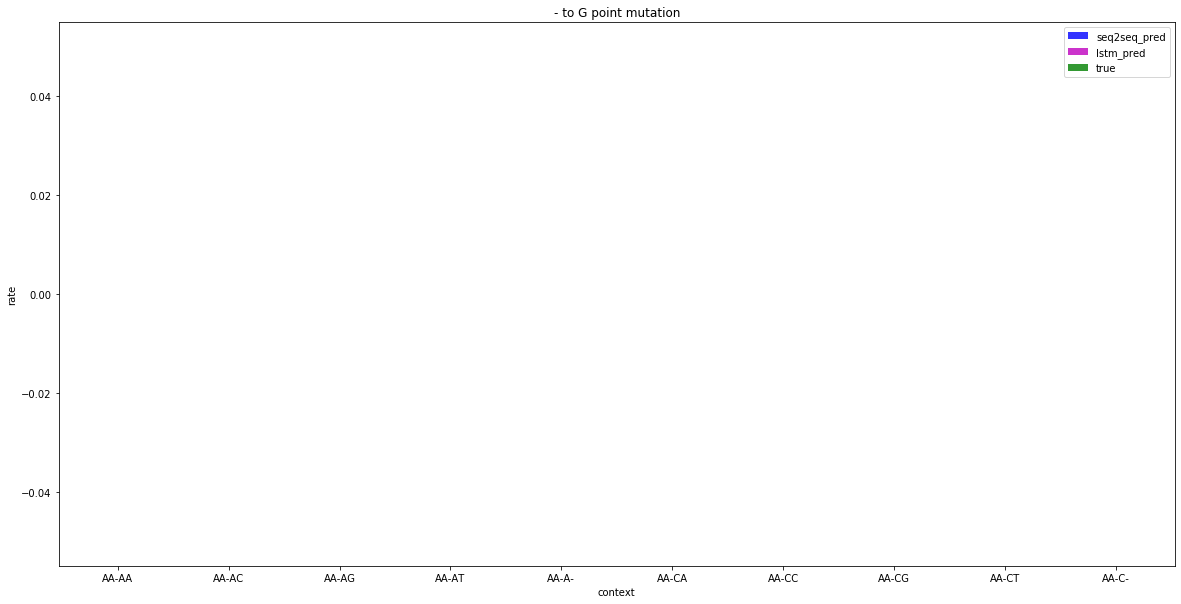

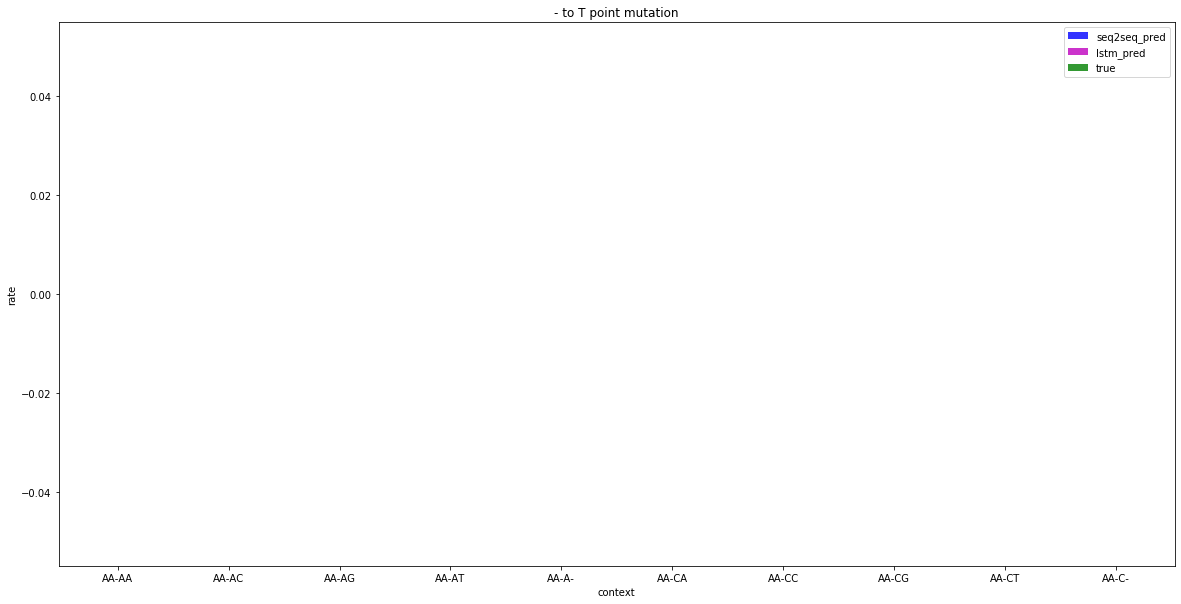

In [5]:
def valueFloat(data_list):
    newDict = dict(zip(data_list.keys(), [float(value) for value in data_list.values()]))
    return newDict
def plotPointMut(n_groups,ancNuc, desNuc):
    predSeq = np.load('data/pred_context{}{}.npy'.format(ancNuc,desNuc), allow_pickle = True).item()

    trueSeq = np.load('data/true_context{}{}.npy'.format(ancNuc,desNuc), allow_pickle = True).item()

    evolSeq = np.load('data/true_evol_context{}{}.npy'.format(ancNuc,desNuc), allow_pickle = True).item()
    
    lstmSeq = np.load('data/pred_lstm_context{}{}.npy'.format(ancNuc,desNuc), allow_pickle = True).item()

    true = list(trueSeq.values())[:n_groups]
    true_context = list(trueSeq.keys())[:n_groups]
    pred = []
    evol = []
    lstm = []
    for i in true_context:
        pred.append(predSeq[i])
        evol.append(evolSeq[i])
        lstm.append(lstmSeq[i])

    # create plot
    fig, ax = plt.subplots(figsize=(20, 10))
    index = np.arange(n_groups)
    bar_width = 0.05
    opacity = 0.8

    rects1 = plt.bar(index, pred, bar_width,
    alpha=opacity,
    color='b',
    label='seq2seq_pred')
    
    rects2 = plt.bar(index + bar_width, lstm, bar_width,
    alpha=opacity,
    color='m',
    label='lstm_pred')
    
    rects3 = plt.bar(index + bar_width*2, true, bar_width,
    alpha=opacity,
    color='g',
    label='true')
    
#     rects3 = plt.bar(index + bar_width*3, evol, bar_width,
#     alpha=opacity,
#     color='r',
#     label='evol_pred')

    plt.xlabel('context')
    plt.ylabel('rate')
    plt.title('{} to {} point mutation'.format(ancNuc, desNuc))
    plt.xticks(index + bar_width, list(trueSeq.keys())[:n_groups])
    plt.legend()

    #plt.tight_layout()
    plt.show()
    plt.close()
    


for i in ancCase:
    for j in desCase:
        if i != j:
            plotPointMut(numBin,i, j)


 

In [27]:
def analyzeMut(ancNuc, desNuc):
    predSeq = np.load('data/pred_context{}{}.npy'.format(ancNuc,desNuc), allow_pickle = True).item()
    trueSeq = np.load('data/true_context{}{}.npy'.format(ancNuc,desNuc), allow_pickle = True).item()
    evolSeq = np.load('data/true_evol_context{}{}.npy'.format(ancNuc,desNuc), allow_pickle = True).item()
    lstmSeq = np.load('data/pred_lstm_context{}{}.npy'.format(ancNuc,desNuc), allow_pickle = True).item()

    print(list(predSeq.keys())[:256])
    print(list(trueSeq.keys())[:256])
    
analyzeMut('G','A')


['CCGTA', 'CCGTC', 'ACGTA', 'GCGTA', 'TCGTT', 'CCGTG', 'GCGTT', 'CCGCA', 'GCGGT', 'GCGTG', 'ACGCA', 'TCGAT', 'ACGTT', 'CCGGA', 'TCGTA', 'CCGTT', 'TCGTC', 'GCGCA', 'GCGTC', 'CCGCG', 'TCGTG', 'TCGCT', 'CCGCT', 'ACGTG', 'CCGAA', 'TCGGT', 'CCGAC', 'ACGCC', 'CCGGG', 'GCGAT', 'GCGGA', 'TCGAA', 'TCGCG', 'GCGCT', 'GCGGG', 'TCGCC', 'ACGAA', 'ACGAT', 'TCGCA', 'TCGGA', 'TCGGG', 'CCGGT', 'GCGAC', 'CCGGC', 'ACGTC', 'CCGCC', 'ACGCT', 'CCGAG', 'ACGGG', 'TCGAG', 'TCGGC', 'GCGCC', 'GCGGC', 'GCGCG', 'GCGAA', 'ACGAC', 'ACGGA', 'ACGCG', 'ACGGT', 'ACGGC', 'GCGAG', 'CCGAT', 'ACGAG', 'TCGAC', 'CTGTA', 'CGGTA', 'ATGTA', 'GTGTA', 'GGGTC', 'GGGTG', 'CAGTT', 'GTGTG', 'CAGTA', 'ATGTG', 'CTGTT', 'GGGAT', 'TGGGT', 'CTGTG', 'GGGGT', 'ATGTC', 'GGGTA', 'GGGCC', 'TGGTT', 'GGGGG', 'CTGTC', 'GGGGA', 'AGGCT', 'CAGTG', 'ATGTT', 'GAGGA', 'CGGGT', 'ATGAG', 'TGGTA', 'AGGTT', 'GTGCA', 'AGGGT', 'TTGTA', 'GGGAA', 'GTGGC', 'ATGGG', 'AGGTG', 'TGGTG', 'CGGTT', 'TGGTC', 'ATGGT', 'CGGCA', 'GGGGC', 'GGGTT', 'GAGTG', 'GGGAC', 'CTGCA', 

In [6]:
# def freqCases(mutList):
#     sum = 0
#     for item in mutList:
#         sum += item[1]
#     print(sum)

# freqCases(pred_contextAG)
# freqCases(pred_contextAgap)

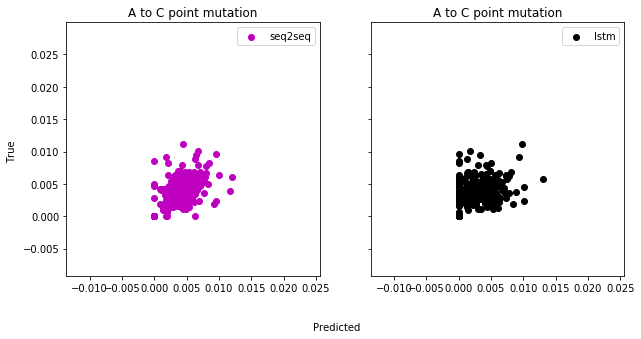

(0.8333686422066656, 1.455171689826088e-162) (0.6680169457397003, 5.271411345398118e-82)


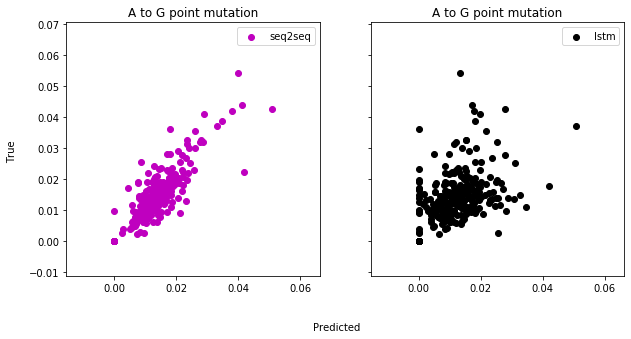

(0.9450483402693338, 1.083496757047272e-304) (0.7625827914341474, 5.879792286337993e-120)


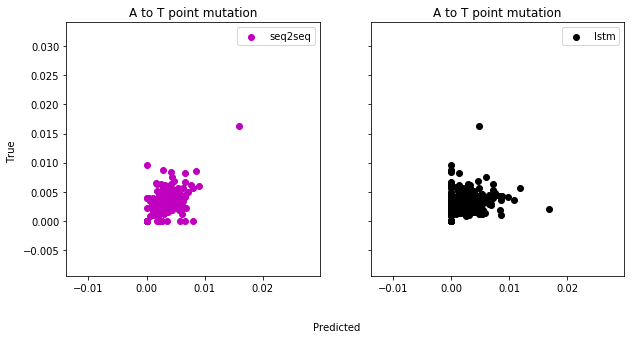

(0.8084112101900455, 1.595441936544896e-145) (0.5553806156205949, 7.309668855408895e-52)


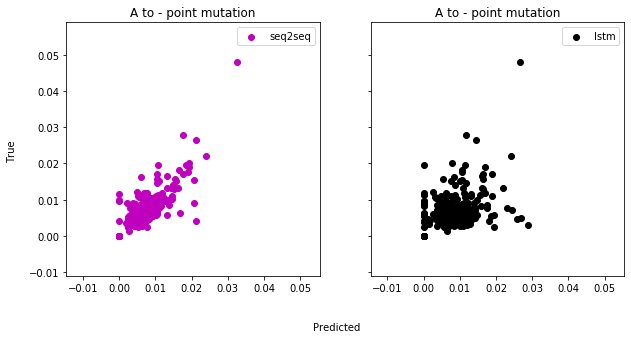

(0.897950526034771, 3.0297027587924187e-224) (0.7108693821890335, 2.690987666089565e-97)


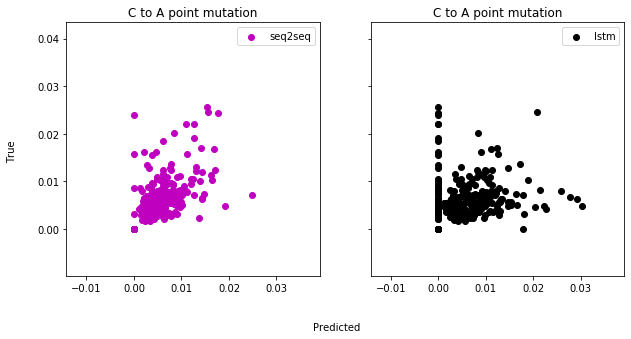

(0.7751041209271021, 2.4556216108625073e-126) (0.5059189365069221, 6.33552439398624e-42)


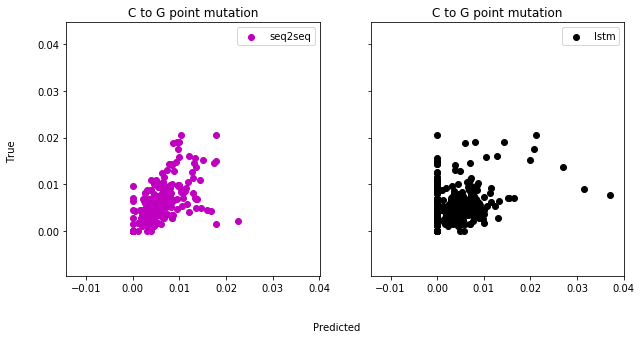

(0.8081553682292884, 2.314246211030132e-145) (0.5657171954264729, 3.713926591972707e-54)


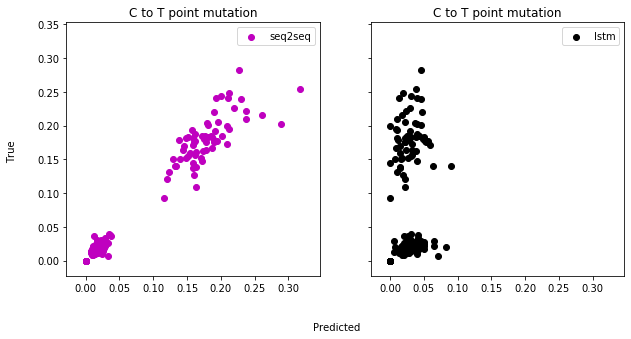

(0.9865785707409864, 0.0) (0.4867596449809085, 1.7097148062302523e-38)


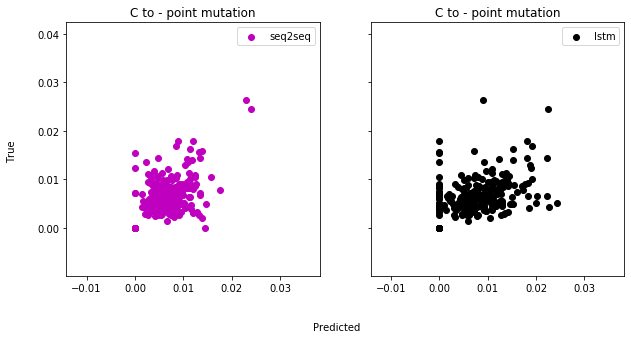

(0.8135399272377526, 8.174835407418773e-149) (0.7417132094163366, 3.696396018811514e-110)


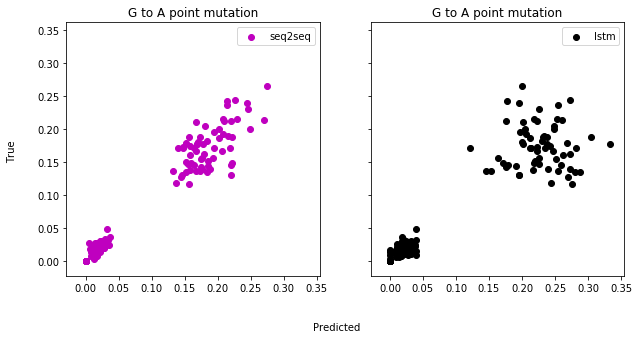

(0.9852482112763037, 0.0) (0.958412126764846, 0.0)


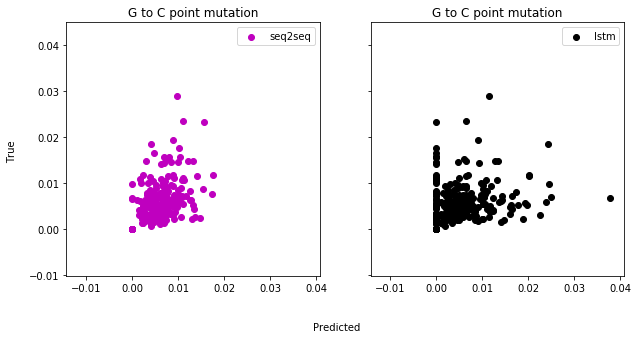

(0.7604949730780438, 6.232544497138549e-119) (0.5273103109572976, 5.0638716384058715e-46)


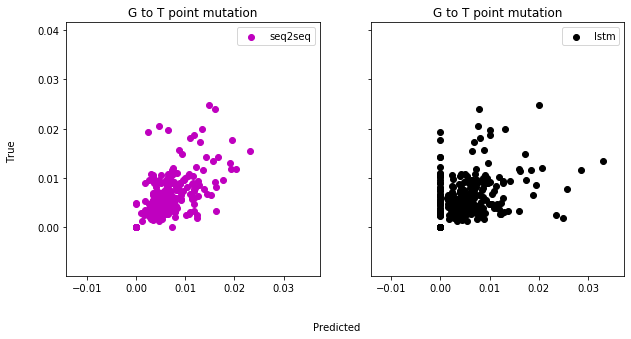

(0.8148970517536971, 1.0585682562036418e-149) (0.6325200397592505, 3.7855266604234606e-71)


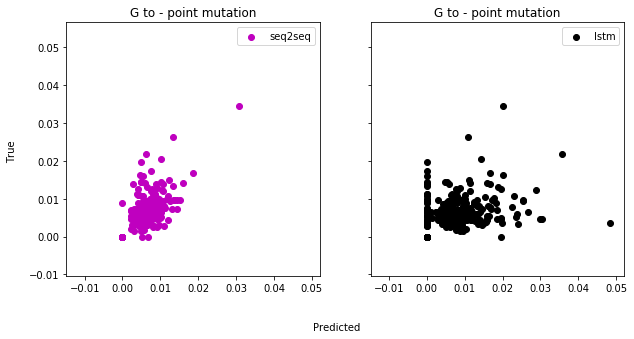

(0.8418900045902833, 4.8356094197646585e-169) (0.6221326284118921, 3.109332594848697e-68)


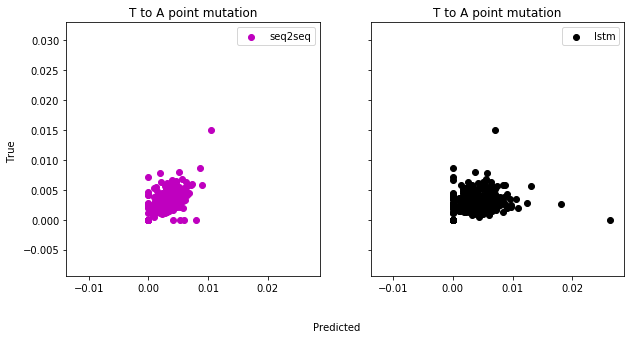

(0.823160755079021, 2.8604434557503363e-155) (0.6155885878124241, 1.8757523853056963e-66)


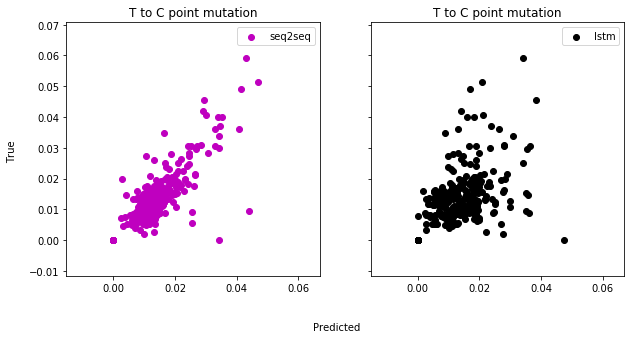

(0.9193008190944038, 1.6971861072724649e-254) (0.7750349251106279, 2.6701995472305825e-126)


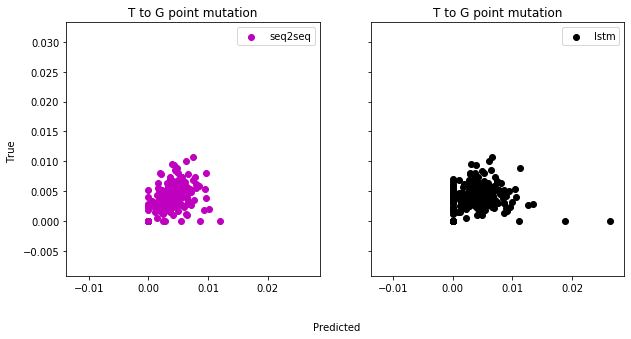

(0.8074840585847122, 6.1248175954462e-145) (0.6052911986814944, 9.808592316820694e-64)


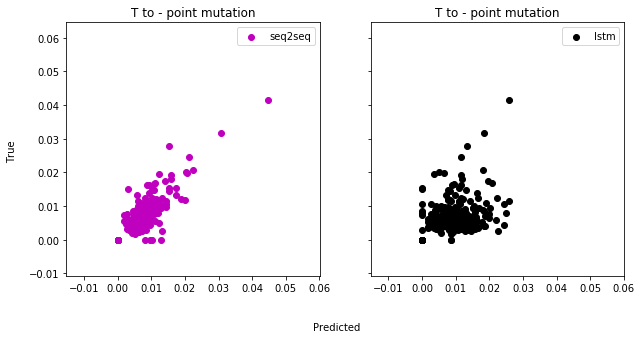

(0.9122488199762899, 1.1712463265398646e-243) (0.7093679782537573, 1.029754650561517e-96)


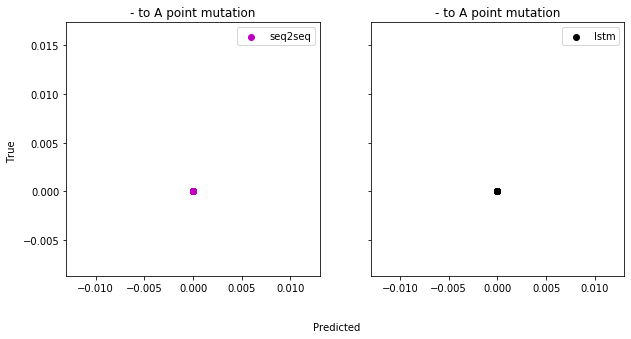

/home/mcb/users/dlim63/miniconda3/envs/research/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(nan, nan) (nan, nan)


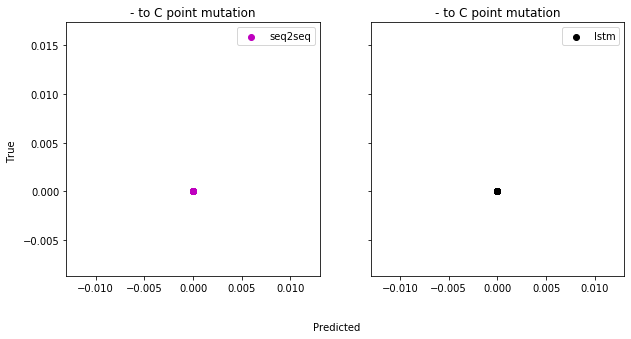

(nan, nan) (nan, nan)


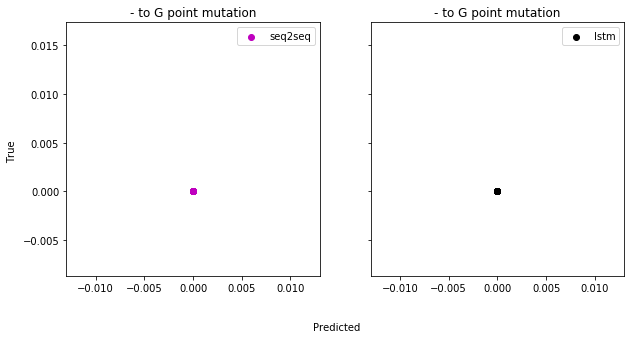

(nan, nan) (nan, nan)


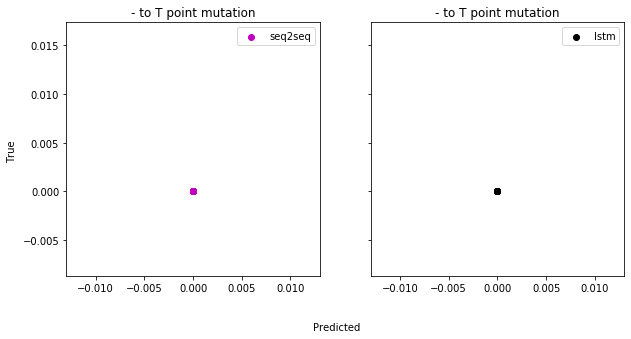

(nan, nan) (nan, nan)


In [9]:
def plotScatter(n_groups, ancNuc, desNuc):
    predSeq = np.load('data/pred_context{}{}.npy'.format(ancNuc,desNuc), allow_pickle = True).item()

    trueSeq = np.load('data/true_context{}{}.npy'.format(ancNuc,desNuc), allow_pickle = True).item()

    evolSeq = np.load('data/true_evol_context{}{}.npy'.format(ancNuc,desNuc), allow_pickle = True).item()
    
    lstmSeq = np.load('data/pred_lstm_context{}{}.npy'.format(ancNuc,desNuc), allow_pickle = True).item()

    true = list(trueSeq.values())
    true_context = list(trueSeq.keys())
    pred = []
    evol = []
    lstm = []
    for i in true_context:
        pred.append(predSeq[i])
        evol.append(evolSeq[i])
        lstm.append(lstmSeq[i])
    f, (ax1, ax3) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,7))
    f.text(0.5, 0.15, 'Predicted', ha='center', va='center')
    f.text(0.05, 0.5, 'True', ha='center', va='center', rotation='vertical')
    ax1.scatter(pred, true, color = 'm', label = 'seq2seq')
#     ax1.xlabel('Predicted')
#     ax1.ylabel('True')
    ax1.axis('scaled')
    ax1.axis('square')
    ax1.set_title('{} to {} point mutation'.format(ancNuc, desNuc))

    ax1.legend()
    

    
#     ax2.scatter(evol, true, color = 'r', label = 'evolver')
#     ax2.xlabel('Predicted')
#     ax2.ylabel('True')
#     ax2.axis('scaled')
#     ax2.axis('square')
#     ax2.set_title('{} to {} point mutation'.format(ancNuc, desNuc))
#     ax2.legend()

    
    ax3.scatter(lstm, true, color = 'k', label = 'lstm')
#     ax3.xlabel('Predicted')
#     ax3.ylabel('True')
    ax3.axis('scaled')
    ax3.axis('square')
    ax3.legend()
    ax3.set_title('{} to {} point mutation'.format(ancNuc, desNuc))
    f.savefig('figures/scatter_{}_{}_{}_{}_{}->{}.png'.format(ancName, desName, train_size, seq_length, ancNuc, desNuc))
    f.show()
    plt.show()
    plt.close()
    print(stats.pearsonr(pred, true), stats.pearsonr(lstm, true))

for i in ancCase:
    for j in desCase:
        if i != j:
            plotScatter(numBin,i, j)


In [ ]:
print(evol_anc[-1])
for i in range(1000):
    print(evol_anc[i])
    print(evol_des[i])